In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from dataset import DrumPatternDataset
from hierarchical_vae import HierarchicalDrumVAE

from torch.utils.data import DataLoader
import random

device = torch.device('mps')

In [2]:
model = HierarchicalDrumVAE(z_high_dim=4, z_low_dim=12)
model.load_state_dict(torch.load("results/best_model.pth", map_location=device))
model.to(device)
model.eval()

/var/folders/hc/52j22vds6db7v04zbb99g60m0000gn/T/ipykernel_99802/2963219396.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("results/bes

HierarchicalDrumVAE(
  (encoder_low): Sequential(
    (0): Conv1d(9, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu_low): Linear(in_features=512, out_features=12, bias=True)
  (fc_logvar_low): Linear(in_features=512, out_features=12, bias=True)
  (encoder_high): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
  )
  (fc_mu_high): Linear(in_features=32, out_features=4, bias=True)
  (fc_logvar_high): Linear(in_features=32, out_features=4, bias=True)
  (decoder_low): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=512, bias=True)
    (3): ReLU()
  )
  (

In [3]:
data_dir = '../data/drums'
dataset = DrumPatternDataset(data_dir, split='val')
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

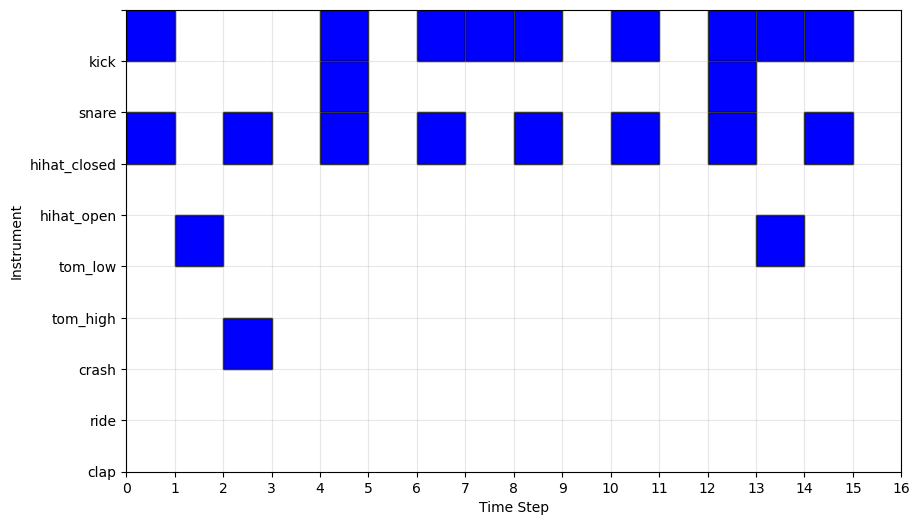

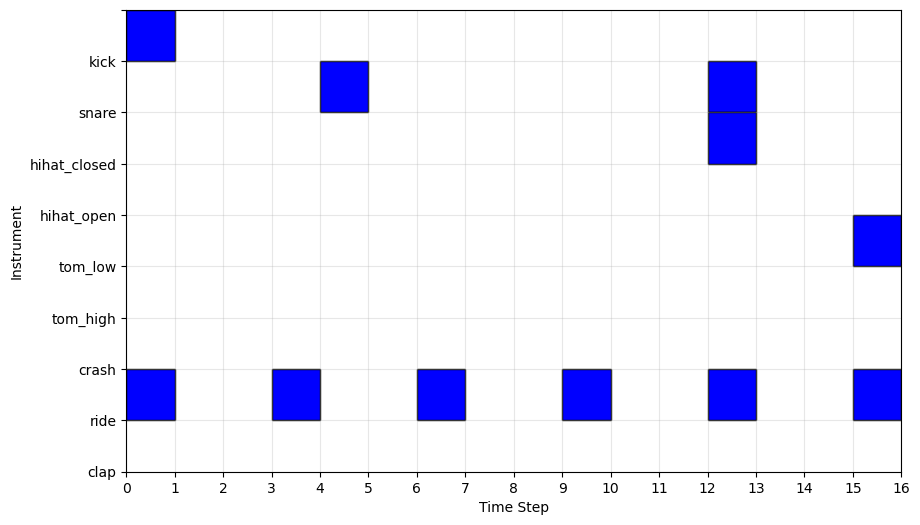

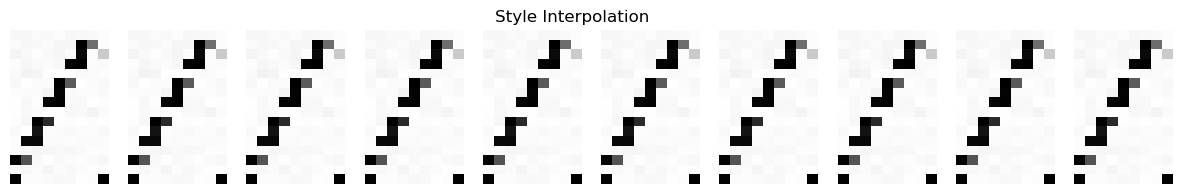

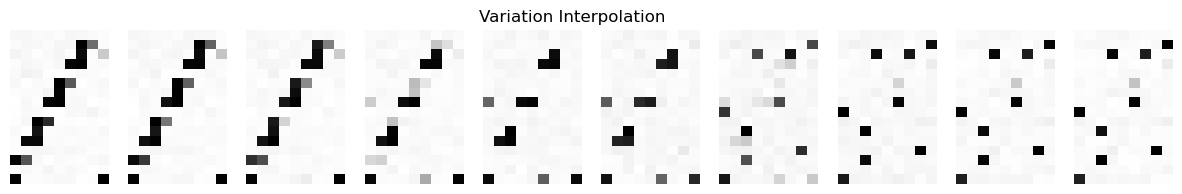

IndexError: index 9 is out of bounds for axis 0 with size 9

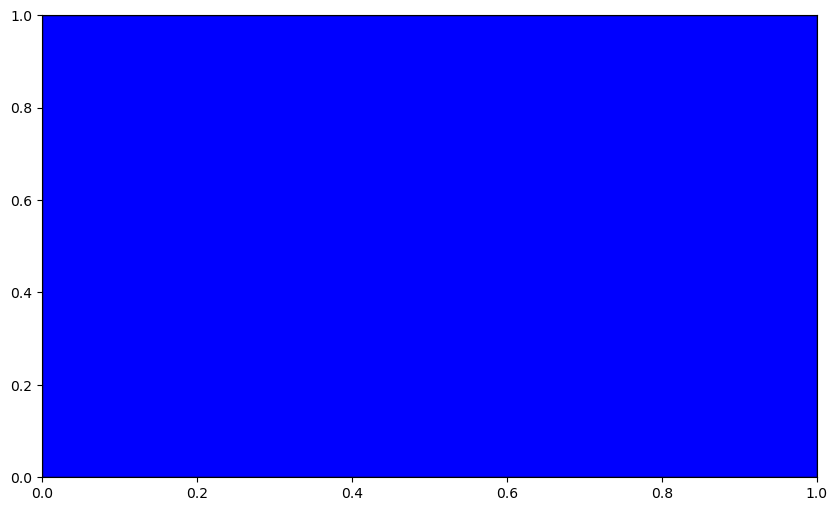

In [4]:
from analyze_latent import interpolate_styles

sample1 = None
sample2 = None

for pattern, style, density in dataset:
    if style == 0 and sample1 is None:
        sample1 = pattern
        fig1 = dataset.pattern_to_pianoroll(pattern)
    elif style == 1 and sample2 is None:
        sample2 = pattern
        fig2 = dataset.pattern_to_pianoroll(pattern)
    if sample1 is not None and sample2 is not None:
        break
        

style_interpolated, variation_interpolated = interpolate_styles(model, sample1, sample2,
                                                                 n_steps=10, device=device)

fig3 = dataset.pattern_to_pianoroll(style_interpolated.T)
fig4 = dataset.pattern_to_pianoroll(variation_interpolated.T)

plt.show()

In [ ]:
from analyze_latent import visualize_latent_hierarchy

visualize_latent_hierarchy(model, data_loader, device)

In [ ]:
from analyze_latent import measure_disentanglement

measure_disentanglement(model, data_loader, device)

In [ ]:
from analyze_latent import controllable_generation

controllable_generation(model, genre_labels, device)

In [5]:
style_interpolated.shape

(9, 16)

In [6]:
pattern.shape

torch.Size([16, 9])